In [1]:
import numpy as np
import pandas as pd
import warnings 
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import plot_confusion_matrix

import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
import string
from wordcloud import WordCloud
from collections import Counter
from nltk.stem.snowball import SnowballStemmer

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import *
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
df = pd.read_csv('/kaggle/input/sms-spam-collection-dataset/spam.csv', encoding = 'latin', usecols = ['v1','v2'])
df

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


# EDA

In [3]:
df.columns = ['label','text']

In [4]:
df.isnull().sum()

label    0
text     0
dtype: int64

In [5]:
df.duplicated().sum()

403

In [6]:
df.drop_duplicates(inplace = True)

In [7]:
df.describe()

,label,text
count,5169,5169
unique,2,5169
top,ham,"Go until jurong point, crazy.. Available only ..."
freq,4516,1


In [8]:
df['label'].value_counts()

label
ham     4516
spam     653
Name: count, dtype: int64

In [9]:
df['text'].tail()

5567    This is the 2nd time we have tried 2 contact u...
5568                Will Ì_ b going to esplanade fr home?
5569    Pity, * was in mood for that. So...any other s...
5570    The guy did some bitching but I acted like i'd...
5571                           Rofl. Its true to its name
Name: text, dtype: object

# PreProcessing

In [10]:
df['label'] = df['label'].map({'spam':1,
                              'ham':0})


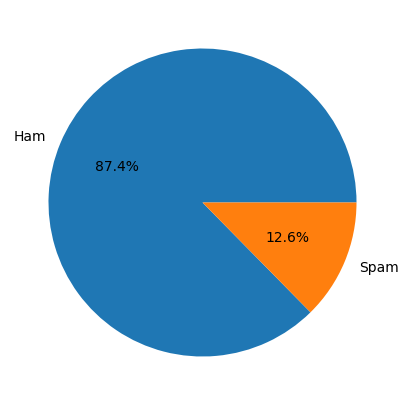

In [11]:
total_0, total_1 = len(df[df["label"] == 0]), len(df[df["label"] == 1])
label = np.array(["Ham", "Spam"])
values = np.array([total_0, total_1])
plt.figure(figsize=(5, 5))
plt.pie(values, labels=label, autopct="%.1f%%")
plt.show()

In [12]:
stop_words = set(stopwords.words('english'))


In [13]:
def clean(text):
    text = text.lower()
    text = " ".join([i for i in text.split() if i  not in stop_words])
    stem = SnowballStemmer("english")
    text = " ".join([stem.stem(i) for i in text.split()])
    
    return text

In [14]:
df['text'] = df['text'].apply(clean)

# Feature Scaling

In [15]:
X = df['text']
y = df['label']

In [16]:
Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size = 0.2,random_state = 43, stratify = y)

In [17]:
tfidf = TfidfVectorizer(ngram_range = (1,3))
cv = CountVectorizer(ngram_range = (1,3))

Xtrain_idf = tfidf.fit_transform(Xtrain)
Xtest_idf = tfidf.transform(Xtest)

Xtrain_cv = cv.fit_transform(Xtrain)
Xtest_cv = cv.transform(Xtest)

# Modelling

## MultinomialNB + TFIDF

In [18]:
mnb = MultinomialNB()

params = {'alpha':[0.1,0.5,0.8,1,2,5,7,10]}

rcv = RandomizedSearchCV(mnb,
                        params,
                        scoring = 'accuracy',
                        cv = 10,
                         n_jobs = -1,
                         random_state = 3,
                         verbose = 3
                        )

In [19]:
rcv.fit(Xtrain_idf,ytrain)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


RandomizedSearchCV(cv=10, estimator=MultinomialNB(), n_jobs=-1,
                   param_distributions={'alpha': [0.1, 0.5, 0.8, 1, 2, 5, 7,
                                                  10]},
                   random_state=3, scoring='accuracy', verbose=3)

In [20]:
print('Best Score is ',rcv.best_score_,' for ',rcv.best_params_)

Best Score is  0.9673497795089541  for  {'alpha': 0.5}


In [21]:
mnb_idf = MultinomialNB(alpha = 0.5)

mnb_idf.fit(Xtrain_idf,ytrain)

y_pred_idf = mnb_idf.predict(Xtest_idf)

print(classification_report(ytest,y_pred_idf))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       903
           1       1.00      0.75      0.86       131

    accuracy                           0.97      1034
   macro avg       0.98      0.87      0.92      1034
weighted avg       0.97      0.97      0.97      1034



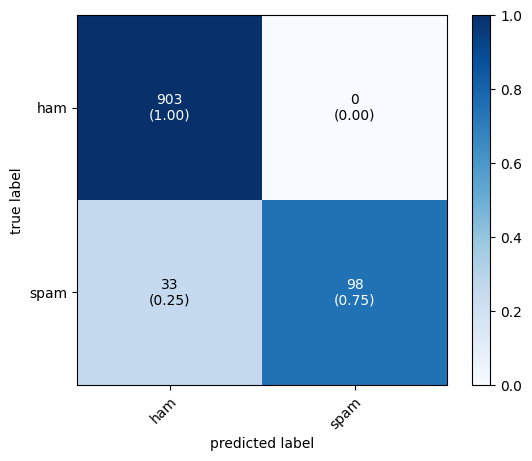

In [22]:
cm = confusion_matrix(ytest, y_pred_idf)
fig, ax = plot_confusion_matrix(conf_mat=cm , show_absolute=True, show_normed=True, colorbar=True, class_names=["ham", "spam"])

plt.show()

In [23]:
print('Train Accuracy - ', accuracy_score(ytrain,mnb_idf.predict(Xtrain_idf)))
print("Test Accuracy - ", accuracy_score(ytest,y_pred_idf))

Train Accuracy -  0.9961305925030229
Test Accuracy -  0.9680851063829787


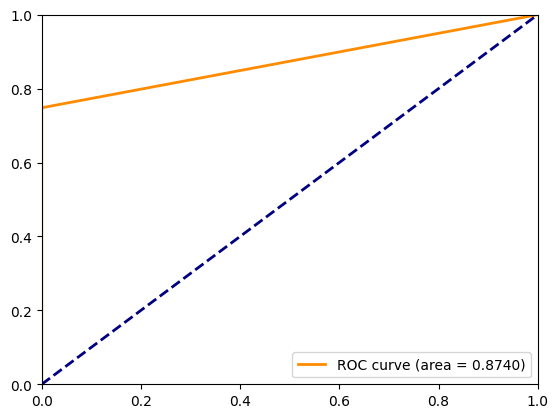

In [24]:
fpr, tpr, _ = roc_curve(ytest, y_pred_idf)
mnb_cv_roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {mnb_cv_roc_auc :.4f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc="lower right")

## MultinomialNB + CountVectorizer

In [25]:
rcv.fit(Xtrain_cv,ytrain)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


RandomizedSearchCV(cv=10, estimator=MultinomialNB(), n_jobs=-1,
                   param_distributions={'alpha': [0.1, 0.5, 0.8, 1, 2, 5, 7,
                                                  10]},
                   random_state=3, scoring='accuracy', verbose=3)

In [26]:
print('Best Score is ',rcv.best_score_,' for ',rcv.best_params_)

Best Score is  0.9845205928109391  for  {'alpha': 5}


In [27]:
mnb_cv = MultinomialNB(alpha = 5)

mnb_cv.fit(Xtrain_cv,ytrain)

y_pred_cv = mnb_cv.predict(Xtest_cv)

print(classification_report(ytest,y_pred_cv))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       903
           1       1.00      0.85      0.92       131

    accuracy                           0.98      1034
   macro avg       0.99      0.93      0.96      1034
weighted avg       0.98      0.98      0.98      1034



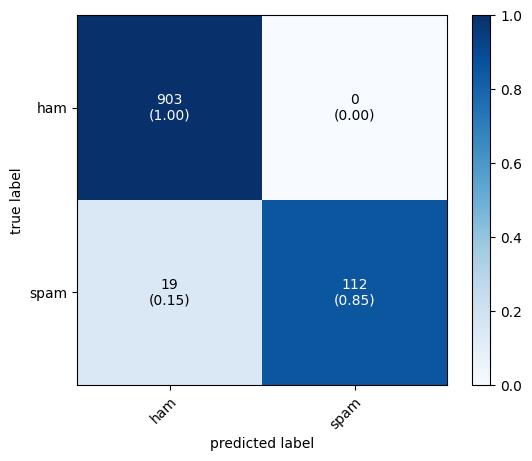

In [28]:
cm = confusion_matrix(ytest, y_pred_cv)
fig, ax = plot_confusion_matrix(conf_mat=cm , show_absolute=True, show_normed=True, colorbar=True, class_names=["ham", "spam"])

plt.show()

In [29]:
print('Train Accuracy - ', accuracy_score(ytrain,mnb_cv.predict(Xtrain_cv)))
print("Test Accuracy - ", accuracy_score(ytest,y_pred_cv))

Train Accuracy -  0.9951632406287787
Test Accuracy -  0.9816247582205029


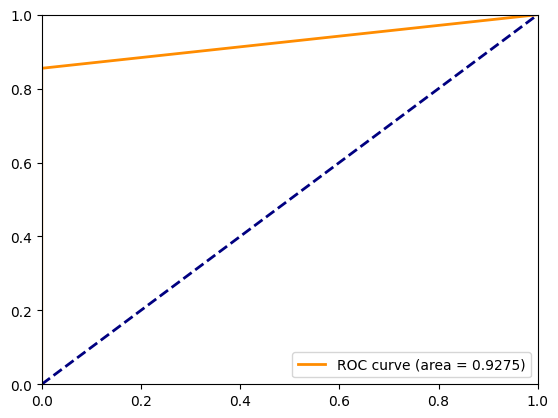

In [30]:
fpr, tpr, _ = roc_curve(ytest, y_pred_cv)
mnb_cv_roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {mnb_cv_roc_auc :.4f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc="lower right")